# Load data

In [2]:
import os
import gc
import pandas as pd

import pickle
from collections import Counter
from tqdm import tqdm
import numpy as np
import random

import json
import ast
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

In [169]:
with open(f"{os.getcwd()}//data/author_to_controversialIndex_byRedditor.pkl", "rb") as f:
    author_to_testHardIdx = pickle.load(f)
author_cnt = {_author:len(author_to_testHardIdx[_author]) for _author in author_to_testHardIdx}
author_cnt = sorted(author_cnt.items(), key=lambda x:x[1], reverse=True)
AUTHORS = [elem[0] for elem in author_cnt[:100]]

"""
author_to_controversialRatio:
- closer to 0 -> tend to participate on non-controversial situations
- closer to 1 -> tend to participate on more controversial situations
"""
author_to_controversialRatio = {} # 
for _author in author_to_testHardIdx:
    author_to_controversialRatio[_author] = sum(author_to_testHardIdx[_author])/len(author_to_testHardIdx[_author])

In [170]:

"""
author_to_judgmentPatterns:
- closer to 0 -> tend to say 'not acceptable' more
- closer to 1 -> tend to say 'acceptable' more
- closer to 0.5 -> balanced judgment
"""

with open(f"{os.getcwd()}//data/subID_to_votes.pkl", "rb") as f:
    subID_to_votes = pickle.load(f)
with open(f"{os.getcwd()}//data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)
    
author_to_judgmentPatterns, author_to_numInst, author_to_numInst_log = {}, {}, {}
for _author in author_to_subID_to_inst:
    _patterns = []
    for _subID in author_to_subID_to_inst[_author]:
        _patterns.append(author_to_subID_to_inst[_author][_subID]['judgment'])
    author_to_judgmentPatterns[_author] = 1-abs(0.5-sum(_patterns)/len(_patterns))*2
    author_to_numInst[_author] = len(_patterns)
    author_to_numInst_log[_author] = np.log(len(_patterns))

In [171]:
"""
author_to_majorityRatio:
- closer to 0 -> tend to align with majority 
- closer to 1 -> tend to be outlier
"""

author_to_majorityRatio = {}
for _author in author_to_subID_to_inst:
    _tendencies = []
    for _subID in author_to_subID_to_inst[_author]:
        _val = sum(subID_to_votes[_subID])/len(subID_to_votes[_subID])
        _majority = round(_val)
        _judgment = author_to_subID_to_inst[_author][_subID]['judgment']
        
        if _majority != _judgment and (_val < 0.3 or _val > 0.7):
            _tendencies.append(1)
        else:
            _tendencies.append(0)

    author_to_majorityRatio[_author] = sum(_tendencies)/len(_tendencies)

In [172]:
author_to_numInst_judgmentPatterns = {}
for _author in author_to_subID_to_inst:
    author_to_numInst_judgmentPatterns[_author] = author_to_numInst_log[_author] * author_to_judgmentPatterns[_author]

In [173]:
from sklearn.preprocessing import QuantileTransformer

def flatten_attr_dict(attr_dict, n_quantiles=10):
    _authors, _list = [], []
    for _author in attr_dict:
        _authors.append(_author)
        _list.append(attr_dict[_author])
    quantile_transformer = QuantileTransformer(output_distribution='uniform', n_quantiles=n_quantiles)
    data = np.array(_list).reshape(-1, 1)
    transformed_data = [elem[0] for elem in quantile_transformer.fit_transform(data)]
    return_dict = {}
    for _author, _mapped_data in zip(_authors, transformed_data):
        return_dict[_author] = _mapped_data
    return return_dict

author_to_numInst_flat = flatten_attr_dict(author_to_numInst)
author_to_majorityRatio_flat = flatten_attr_dict(author_to_majorityRatio)
author_to_controversialRatio_flat = flatten_attr_dict(author_to_controversialRatio)
author_to_judgmentPatterns_flat = flatten_attr_dict(author_to_judgmentPatterns)
author_to_numInst_judgmentPatterns_flat = flatten_attr_dict(author_to_numInst_judgmentPatterns)

In [ ]:
df_ext = pd.read_csv(f'{os.getcwd()}/data/data_active_authorExt_withAbstValues.tsv', sep='\t')
df_ext

In [4]:
with open(f"{os.getcwd()}/data/author_to_subID_to_schwartz_4o.pkl", "rb") as f:
    author_to_subID_to_schwartz = pickle.load(f)
print(author_to_subID_to_schwartz['NoApollonia']['k8zq74'])

Self-Direction, Benevolence


# Author grouping

1. For each author, gather abstract values (AbstValue, Schwartz, (Clustered?)) from each comment
2. For Schwartz,  
   2-1. For each author, count the schwartz value  
   2-2. If the two align a lot, they can be grouped together  
3. For AbstValue,  
   3-1. Winrate of trade-offs  
   3-2. If the users have similar value preference, they are grouped together  

## Group by schwartz

In [5]:
author_to_schwartz_cnt = {}
for _author in author_to_subID_to_schwartz:
    author_to_schwartz_cnt[_author] = {}
    for _subID in author_to_subID_to_schwartz[_author]:
        for _val in author_to_subID_to_schwartz[_author][_subID].split(', '):
            if _val not in author_to_schwartz_cnt[_author]:
                author_to_schwartz_cnt[_author][_val] = 1
            else:
                author_to_schwartz_cnt[_author][_val] += 1

/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_79809/3751961020.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')


<Axes: xlabel='author', ylabel='percent'>

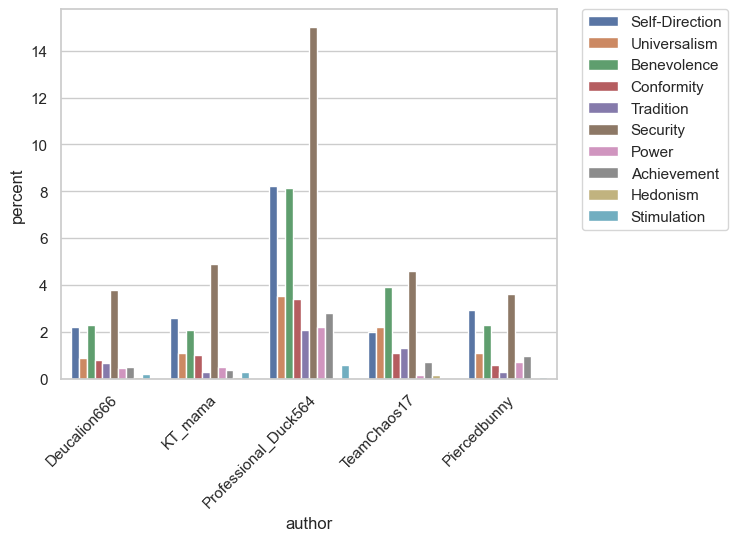

In [6]:
AUTHORS = list(author_to_schwartz_cnt.keys())
schwartz_values = ['Self-Direction', 'Universalism', 'Benevolence', 'Conformity', 'Tradition', 
                   'Security', 'Power', 'Achievement', 'Hedonism', 'Stimulation']

# random.seed(2025)
random.shuffle(AUTHORS)

# _dict = {'author':[], 'value':[], 'percent':[]}
_dict = {'author':[], 'value':[],}
for _author in AUTHORS[:5]:
    vals_sorted = sorted(author_to_schwartz_cnt[_author].items(), key=lambda x:x[1], reverse=True)
    top_vals = [item[0] for item in vals_sorted]
    all_val_cnts = sum([item[1] for item in vals_sorted])
    
    # for _val in top_vals[:5]:
    for _val in schwartz_values:
        if _val not in author_to_schwartz_cnt[_author]:
            continue
        for i in range(author_to_schwartz_cnt[_author][_val]):
            
            _dict['author'].append(_author)
            _dict['value'].append(_val)
        # _dict['percent'].append(author_to_schwartz_cnt[_author][_val]/all_val_cnts*100)
        # _dict['percent'].append(author_to_schwartz_cnt[_author][_val])
df_viz = pd.DataFrame(data=_dict)
g = sns.countplot(data=df_viz, x="author", hue="value", stat="percent")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

In [7]:
schwartz_values = ['self-direction', 'universalism', 'benevolence', 'conformity', 'tradition', 
                   'security', 'power', 'achievement', 'hedonism', 'stimulation']
top_thr = 2

group_to_authors_bySchwartz, authors_to_group_bySchwartz = {}, {}
for _author in author_to_schwartz_cnt:
    vals_sorted = sorted(author_to_schwartz_cnt[_author].items(), key=lambda x:x[1], reverse=True)
    top_vals = [item[0] for item in vals_sorted if item[0].lower() in schwartz_values][:top_thr]
    group_name = "_".join(top_vals)

    if group_name not in group_to_authors_bySchwartz:
        group_to_authors_bySchwartz[group_name] = [_author]
    else:
        group_to_authors_bySchwartz[group_name].append(_author)
    authors_to_group_bySchwartz[_author] = group_name

In [11]:
print(f"Num groups: {len(group_to_authors_bySchwartz.keys())}")
for _group in group_to_authors_bySchwartz:
    print(_group, len(group_to_authors_bySchwartz[_group]))

Num groups: 8
Security_Self-Direction 106
Security_Benevolence 83
Benevolence_Security 26
Security_Conformity 3
Benevolence_Conformity 1
Benevolence_Universalism 1
Self-Direction_Security 5
Benevolence_Self-Direction 1


In [10]:
group_to_authors_bySchwartz.keys()

dict_keys(['Security_Self-Direction', 'Security_Benevolence', 'Benevolence_Security', 'Security_Conformity', 'Benevolence_Conformity', 'Benevolence_Universalism', 'Self-Direction_Security', 'Benevolence_Self-Direction'])

### Analyze voting patterns within each group

In [79]:
group_to_agreements = {}
for _group in group_to_authors_bySchwartz:
    if len(group_to_authors_bySchwartz[_group]) > 20:
        group_authors = group_to_authors_bySchwartz[_group]
        minidf = df_ext[df_ext['author'].isin(group_authors)]
        subID_to_votes, subID_to_len = {}, {}
        for idx, row in minidf.iterrows():
            if row['subID'] not in subID_to_votes:
                subID_to_votes[row['subID']] = []
            subID_to_votes[row['subID']].append(row['judgment'])
        for _subID in subID_to_votes:
            subID_to_len[_subID] = len(subID_to_votes[_subID])
        subID_to_len_sorted = sorted(subID_to_len.items(), key=lambda x:x[1], reverse=True)
        agreements = []
        for _subID in subID_to_votes:
            if len(subID_to_votes[_subID]) >= 10:
                agreements.append(abs(0.5-sum(subID_to_votes[_subID])/len(subID_to_votes[_subID]))*2)
        group_to_agreements[_group] = agreements

/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_38401/4043004787.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_38401/4043004787.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')


<Axes: xlabel='value', ylabel='agreement'>

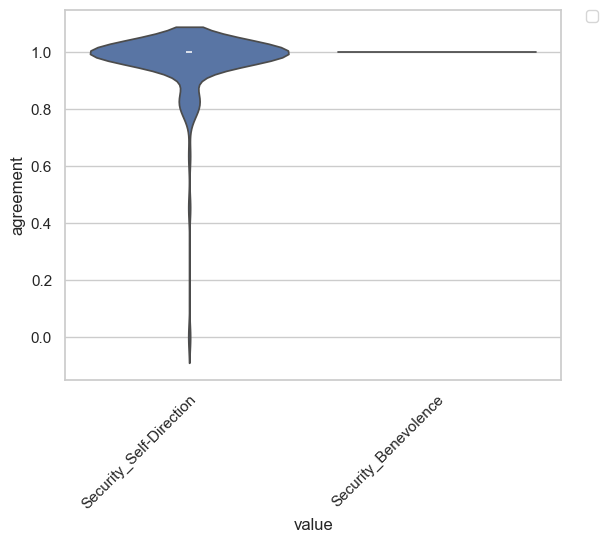

In [81]:
_dict = {'value':[], 'agreement':[], 'subID':[]}
for _group in group_to_agreements:
    for i in range(len(group_to_agreements[_group])):
        _dict['value'].append(_group)
        _dict['agreement'].append(group_to_agreements[_group][i])
        _dict['subID'].append(i)
        
df_viz = pd.DataFrame(data=_dict)
g = sns.violinplot(data=df_viz, x="value", y="agreement",)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

## Group by Value Tradeoff

In [12]:
author_to_tradeoffs = {}
for idx, row in df_ext.iterrows():
    # if row['comm_val_pattern_cats'] != row['comm_val_pattern_cats']:
    if row['comm_val_patterns'] != row['comm_val_patterns']:
        continue
    if row['author'] not in author_to_tradeoffs:
        author_to_tradeoffs[row['author']] = {}
    # tradeoffs = row['comm_val_pattern_cats'].split('\n')
    tradeoffs = row['comm_val_patterns'].split('\n')
    for item in tradeoffs:
        divider = '>' if '>' in item else '<'
        if len(item.split(divider)) != 2:
            continue
        if divider == '>':
            win = item.split(divider)[0].strip()
            lose = item.split(divider)[-1].strip()
        else:
            win = item.split(divider)[-1].strip()
            lose = item.split(divider)[0].strip()
        curr_tradeoff = win + ' > ' + lose
        if curr_tradeoff not in author_to_tradeoffs[row['author']]:
            author_to_tradeoffs[row['author']][curr_tradeoff] = 1
        else:
            author_to_tradeoffs[row['author']][curr_tradeoff] += 1

/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_79809/525558377.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')


<Axes: xlabel='author', ylabel='percent'>

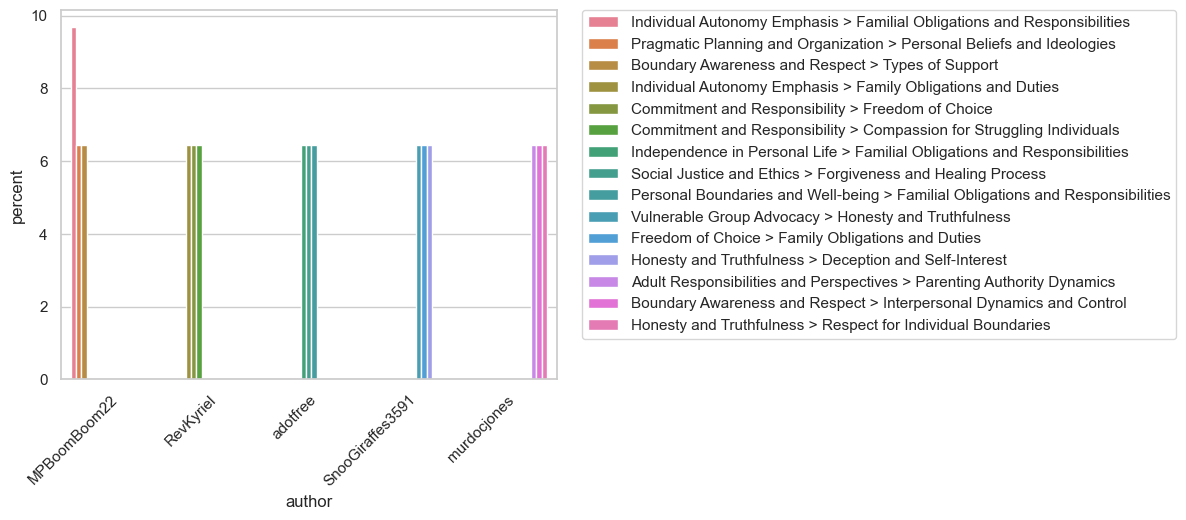

In [13]:
AUTHORS = list(author_to_tradeoffs.keys())

# random.seed(2025)
random.shuffle(AUTHORS)

# _dict = {'author':[], 'value':[], 'percent':[]}
_dict = {'author':[], 'value':[],}
for _author in AUTHORS[:5]:
    vals_sorted = sorted(author_to_tradeoffs[_author].items(), key=lambda x:x[1], reverse=True)
    top_vals = [item[0] for item in vals_sorted]
    
    for _val in top_vals[:3]:
        for i in range(author_to_tradeoffs[_author][_val]):
            _dict['author'].append(_author)
            _dict['value'].append(_val)
            
df_viz = pd.DataFrame(data=_dict)
g = sns.countplot(data=df_viz, x="author", hue="value", stat="percent")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

In [21]:
top_thr = 1

group_to_authors_byAbstValue, authors_to_group_byAbstValue = {}, {}
for _author in author_to_tradeoffs:
    val_to_wins, val_to_lose = {}, {}
    for _val_td in author_to_tradeoffs[_author]:
        _win = _val_td.split('>')[0].strip()
        _lose= _val_td.split('>')[1].strip()
        if _win not in val_to_wins:
            val_to_wins[_win] = 1
        else:
            val_to_wins[_win] += 1
        if _lose not in val_to_lose:
            val_to_lose[_lose] = 1
        else:
            val_to_lose[_lose] += 1
    val_to_winrates = {}
    for _val in list(set(list(val_to_wins.keys())+list(val_to_lose.keys()))):
        if _val not in val_to_wins and _val in val_to_lose:
            val_to_winrates[_val] = 0
            val_to_wins[_val] = 0
        elif _val in val_to_wins and _val not in val_to_lose:
            val_to_winrates[_val] = 1
            val_to_lose[_val] = 0
        elif _val in val_to_wins and _val in val_to_lose:
            val_to_winrates[_val] = val_to_wins[_val]/(val_to_wins[_val]+val_to_lose[_val])
            
    val_to_winrates_sorted = sorted(val_to_winrates.items(), key=lambda x:(val_to_wins[x[0]], x[1]), reverse=True)
    val_to_winrates_sorted = [item for item in val_to_winrates_sorted if item[1] >= 0.7]
    # val_to_winrates_sorted = sorted(val_to_winrates.items(), key=lambda x:(x[1], val_to_wins[x[0]]), reverse=True)
    # print(_author, val_to_winrates_sorted[0], val_to_wins[val_to_winrates_sorted[0][0]])
    # vals_sorted = sorted(author_to_tradeoffs[_author].items(), key=lambda x:x[1], reverse=True)
    top_vals = sorted([item[0] for item in val_to_winrates_sorted][:top_thr])
    group_name = "_".join(top_vals)

    if group_name not in group_to_authors_byAbstValue:
        group_to_authors_byAbstValue[group_name] = [_author]
    else:
        group_to_authors_byAbstValue[group_name].append(_author)
    authors_to_group_byAbstValue[_author] = group_name

In [22]:
print(f"Num authors: {len(authors_to_group_byAbstValue.keys())}")
print(f"Num groups: {len(group_to_authors_byAbstValue.keys())}")

for _group in group_to_authors_byAbstValue:
    print(_group, len(group_to_authors_byAbstValue[_group]))

Num authors: 226
Num groups: 10
Boundary Awareness and Respect 12
Respect and Communication 1
Personal Boundaries and Well-being 91
Individual Autonomy Emphasis 107
Freedom of Choice 3
Commitment and Responsibility 7
Family Tradition Importance 1
Independence in Personal Life 2
Individual Autonomy 1
Honesty and Truthfulness 1


### Analyze voting patterns

In [25]:
group_to_agreements = {}
ungrouped_authors = []
for _group in group_to_authors_byAbstValue:
    # if len(group_to_authors_byAbstValue[_group]) > 20:
    if len(group_to_authors_byAbstValue[_group]) >= 20:
        group_authors = group_to_authors_byAbstValue[_group]
        minidf = df_ext[df_ext['author'].isin(group_authors)]
        subID_to_votes, subID_to_len = {}, {}
        for idx, row in minidf.iterrows():
            if row['subID'] not in subID_to_votes:
                subID_to_votes[row['subID']] = []
            subID_to_votes[row['subID']].append(row['judgment'])
        for _subID in subID_to_votes:
            subID_to_len[_subID] = len(subID_to_votes[_subID])
        subID_to_len_sorted = sorted(subID_to_len.items(), key=lambda x:x[1], reverse=True)
        agreements = []
        for _subID in subID_to_votes:
            if len(subID_to_votes[_subID]) >= 5:
                agreements.append(abs(0.5-sum(subID_to_votes[_subID])/len(subID_to_votes[_subID]))*2)
        group_to_agreements[_group] = agreements
    else:
        ungrouped_authors += group_to_authors_byAbstValue[_group]

In [26]:
minidf = df_ext[df_ext['author'].isin(ungrouped_authors)]
subID_to_votes, subID_to_len = {}, {}
for idx, row in minidf.iterrows():
    if row['subID'] not in subID_to_votes:
        subID_to_votes[row['subID']] = []
    subID_to_votes[row['subID']].append(row['judgment'])
for _subID in subID_to_votes:
    subID_to_len[_subID] = len(subID_to_votes[_subID])
subID_to_len_sorted = sorted(subID_to_len.items(), key=lambda x:x[1], reverse=True)
agreements = []
for _subID in subID_to_votes:
    if len(subID_to_votes[_subID]) >= 5:
        agreements.append(abs(0.5-sum(subID_to_votes[_subID])/len(subID_to_votes[_subID]))*2)
group_to_agreements["Ungrouped"] = agreements

/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_79809/4043004787.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
/var/folders/xg/3nchppc93qd7twxj7g3hstfh0000gn/T/ipykernel_79809/4043004787.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')


<Axes: xlabel='value', ylabel='agreement'>

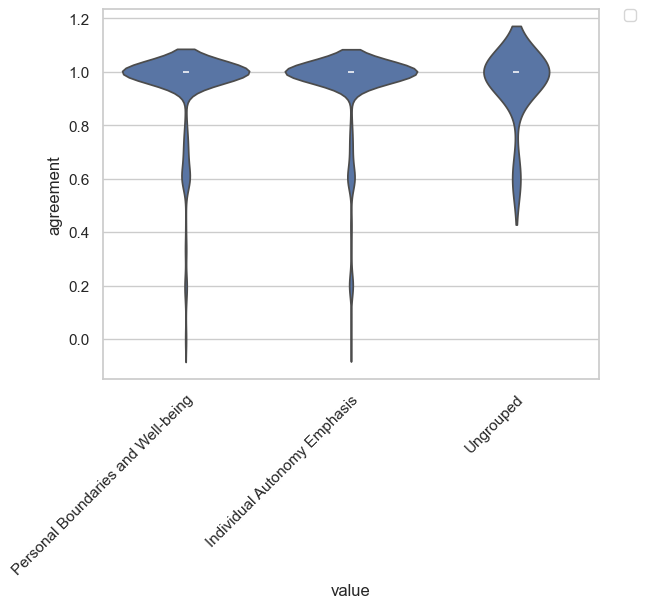

In [27]:
_dict = {'value':[], 'agreement':[], 'subID':[]}
for _group in group_to_agreements:
    for i in range(len(group_to_agreements[_group])):
        _dict['value'].append(_group)
        _dict['agreement'].append(group_to_agreements[_group][i])
        _dict['subID'].append(i)
        
df_viz = pd.DataFrame(data=_dict)
g = sns.violinplot(data=df_viz, x="value", y="agreement",)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

In [28]:
df_viz

,value,agreement,subID
0,Personal Boundaries and Well-being,1.0,0
1,Personal Boundaries and Well-being,1.0,1
2,Personal Boundaries and Well-being,1.0,2
3,Personal Boundaries and Well-being,1.0,3
4,Personal Boundaries and Well-being,1.0,4
...,...,...,...
1981,Ungrouped,0.6,4
1982,Ungrouped,1.0,5
1983,Ungrouped,1.0,6
1984,Ungrouped,1.0,7


# Error Analysis
- For incorrect test situation
- Check the true value trade-off (from their comment)
- Check the overall win-rate of the conflict

In [73]:
author_to_wins, author_to_loses = {}, {}
for idx, row in df_ext.iterrows():
    # if row['comm_val_patterns'] != row['comm_val_patterns']:
    if row['comm_val_pattern_cats'] != row['comm_val_pattern_cats']:
        continue
    if row['author'] not in author_to_wins:
        author_to_wins[row['author']] = {}
    if row['author'] not in author_to_loses:
        author_to_loses[row['author']] = {}

    # tradeoffs = row['comm_val_patterns'].split('\n')
    tradeoffs = row['comm_val_pattern_cats'].split('\n')
    for item in tradeoffs:
        divider = '>' if '>' in item else '<'
        if len(item.split(divider)) != 2:
            continue
        if divider == '>':
            win = item.split(divider)[0].strip()
            lose = item.split(divider)[-1].strip()
        else:
            win = item.split(divider)[-1].strip()
            lose = item.split(divider)[0].strip()

        if win not in author_to_wins[row['author']]:
            author_to_wins[row['author']][win] = 1
        else:
            author_to_wins[row['author']][win] += 1

        if lose not in author_to_loses[row['author']]:
            author_to_loses[row['author']][lose] = 1
        else:
            author_to_loses[row['author']][lose] += 1

In [74]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue', 'Comm-Value', 'RandomAuthor']
inputs =['Comment', 'AbstValue', 'Value', 'Schwartz']
n_trials = 2

In [75]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [82]:
def return_incorect_llm_results(_strategy, _input, target_authors, isHard=False):
    _filename = f"gpt-4.1_5shots_{_strategy}withSelftext_{_input}.jsonl"
    df = pd.read_json(output_dir+_filename, lines=True)
    
    df['author'] = df['custom_id'].apply(lambda x:x.split('-inst_')[0])
    df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
    df['isHard'] = df['custom_id'].apply(lambda x:author_to_testHardIdx[x.split('-inst_')[0]][int(x.split('-inst_')[-1].split('-trial_')[0])])

    with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
        id_to_gold = pickle.load(f)

    df = df[df['author'].isin(target_authors)]
    if isHard:
        df = df[df['isHard']==1]

    # Simplify the setting and just analyze the first trial
    df = df[df['trial']==0]
    _golds = df['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
    _preds = df['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
    _preds = convert_pred_to_digit(_golds, _preds)

    incorrect_IDs, correct_IDs = [], []
    for _ID, _gold, _pred in zip(df['custom_id'].tolist(), _golds, _preds):
        if _gold != _pred:
            incorrect_IDs.append(_ID)
        else:
            correct_IDs.append(_ID)

    return incorrect_IDs, correct_IDs

In [77]:
with open(f"{os.getcwd()}/data/author_to_subID_to_inst.pkl", "rb") as f:
    author_to_subID_to_inst = pickle.load(f)

In [152]:
from _00_data_loader import get_data_split_author

# _author  = 'WebbieVanderquack'
_dict = {'author':[], 'subID':[], 'Avg Winrate':[]}
for _author in AUTHORS:
    _, _, _test_set = get_data_split_author('/data/byRedditor', _author, 100000, 100000, 100000, return_dict=False)
    incorrect_IDs, correct_IDs = return_incorect_llm_results("Situation", "Comment", [_author])
    indices = [int(elem.split("inst_")[-1].split("-trial_")[0]) for elem in incorrect_IDs]
    # indices = [int(elem.split("inst_")[-1].split("-trial_")[0]) for elem in correct_IDs]
    target_subIDs = [_test_set[idx]['subID'] for idx in indices]
    for _subID in target_subIDs:
        winrates = []
        # for _conf in author_to_subID_to_inst[_author][_subID]['abst_value'].split("\n"):
        if author_to_subID_to_inst[_author][_subID]['abst_value_clustered'] != author_to_subID_to_inst[_author][_subID]['abst_value_clustered']:
            continue
        for _conf in author_to_subID_to_inst[_author][_subID]['abst_value_clustered'].split("\n"):
            win = _conf.split(">")[0].strip()
            lose = _conf.split(">")[1].strip()
            try:
                win_orig_cnt = author_to_wins[_author][win]
                lose_orig_cnt = author_to_loses[_author][lose]
                if win_orig_cnt+lose_orig_cnt > len(target_subIDs)*15:
                    winrates.append((win_orig_cnt-1)/(win_orig_cnt-1+lose_orig_cnt))
            except:
                continue
        if len(winrates) == 0:
            continue
        _dict['author'].append(_author)
        _dict['subID'].append(_subID)
        _dict['Avg Winrate'].append(np.mean(winrates))

In [153]:
_num_insts, judgment_patterns, _num_insts_flat, indicator = [], [], [], []
for _author in _dict['author']:
    _num_insts.append(author_to_numInst_log[_author])
    judgment_patterns.append(author_to_judgmentPatterns[_author])
    _num_insts_flat.append(author_to_numInst_flat[_author])
    indicator.append("Incorrect")
_dict['Num Instances (Log)'] = _num_insts
_dict['Num Instances (Scaled)'] = _num_insts_flat
_dict['Judgment Distribution'] = judgment_patterns
_dict['is_correct'] = indicator

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="deep")

In [154]:
from _00_data_loader import get_data_split_author

# _author  = 'WebbieVanderquack'
_dict2 = {'author':[], 'subID':[], 'Avg Winrate':[]}
for _author in AUTHORS:
    _, _, _test_set = get_data_split_author('/data/byRedditor', _author, 100000, 100000, 100000, return_dict=False)
    incorrect_IDs, correct_IDs = return_incorect_llm_results("Situation", "Comment", [_author])
    # indices = [int(elem.split("inst_")[-1].split("-trial_")[0]) for elem in incorrect_IDs]
    indices = [int(elem.split("inst_")[-1].split("-trial_")[0]) for elem in correct_IDs]
    target_subIDs = [_test_set[idx]['subID'] for idx in indices]
    for _subID in target_subIDs:
        winrates = []
        # for _conf in author_to_subID_to_inst[_author][_subID]['abst_value'].split("\n"):
        if author_to_subID_to_inst[_author][_subID]['abst_value_clustered'] != author_to_subID_to_inst[_author][_subID]['abst_value_clustered']:
            continue
        for _conf in author_to_subID_to_inst[_author][_subID]['abst_value_clustered'].split("\n"):
            win = _conf.split(">")[0].strip()
            lose = _conf.split(">")[1].strip()
            try:
                win_orig_cnt = author_to_wins[_author][win]
                lose_orig_cnt = author_to_loses[_author][lose]
                if win_orig_cnt+lose_orig_cnt > len(target_subIDs)*1.5:
                    winrates.append((win_orig_cnt-1)/(win_orig_cnt-1+lose_orig_cnt))
            except:
                continue
        if len(winrates) == 0:
            continue
        _dict2['author'].append(_author)
        _dict2['subID'].append(_subID)
        _dict2['Avg Winrate'].append(np.mean(winrates))

In [155]:
_num_insts, judgment_patterns, _num_insts_flat, indicator = [], [], [], []
for _author in _dict2['author']:
    _num_insts.append(author_to_numInst_log[_author])
    judgment_patterns.append(author_to_judgmentPatterns[_author])
    _num_insts_flat.append(author_to_numInst_flat[_author])
    indicator.append("Correct")
_dict2['Num Instances (Log)'] = _num_insts
_dict2['Num Instances (Scaled)'] = _num_insts_flat
_dict2['Judgment Distribution'] = judgment_patterns
_dict2['is_correct'] = indicator

In [189]:
df_viz_all

,author,subID,Avg Winrate,Num Instances (Log),Num Instances (Scaled),Judgment Distribution,is_correct
0,teresajs,i6otwq,0.624535,7.457032,0.951288,0.090069,Correct
1,teresajs,ebpvil,0.612394,7.457032,0.951288,0.090069,Correct
2,teresajs,ljfi4k,0.624535,7.457032,0.951288,0.090069,Correct
3,teresajs,coui8o,0.624535,7.457032,0.951288,0.090069,Correct
4,teresajs,lp140q,0.612394,7.457032,0.951288,0.090069,Correct
...,...,...,...,...,...,...,...
13,slendermanismydad,uopjca,0.802198,5.407172,0.810897,0.197309,Incorrect
14,CMSkye,lzpv8a,0.649306,5.370638,0.802350,0.176744,Incorrect
15,meifahs_musungs,uopjca,0.660377,5.323010,0.791667,0.204878,Incorrect
16,noccie,ohs0ef,0.590909,5.293305,0.785256,0.472362,Incorrect


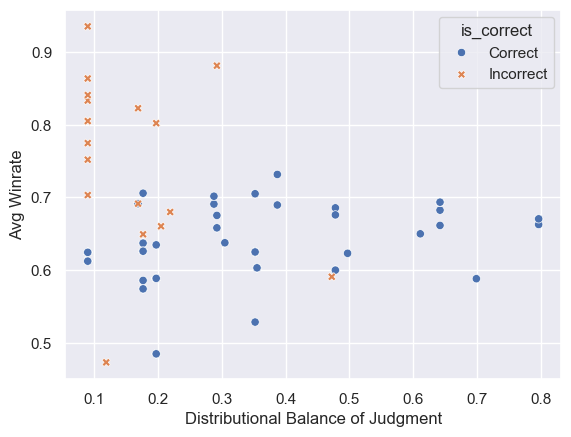

In [190]:
df_viz = pd.DataFrame(data=_dict)
df_viz2 = pd.DataFrame(data=_dict2)
df_viz_all = pd.concat([df_viz2, df_viz])
df_viz_all = df_viz_all.rename(columns={'Judgment Distribution': 'Distributional Balance of Judgment'})
# g2 = sns.scatterplot(data=df_viz_all, x="Num Instances (Scaled)", y="Avg Winrate", hue="is_correct", style="is_correct")
g2 = sns.scatterplot(data=df_viz_all, x="Distributional Balance of Judgment", y="Avg Winrate", hue="is_correct", style="is_correct")
# g2 = sns.scatterplot(data=df_viz2, x="Num Instances (Log)", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
# g

In [191]:
g2.figure.savefig(f'{os.getcwd()}/diagram/Error_Analysis.png', bbox_inches='tight')

<Axes: xlabel='Num Instances (Scaled)', ylabel='avg_winrate'>

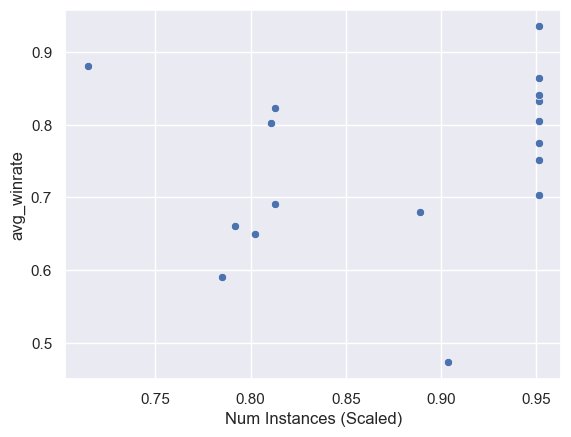

In [117]:
df_viz = pd.DataFrame(data=_dict)
g = sns.scatterplot(data=df_viz, x="Num Instances (Scaled)", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

<Axes: xlabel='Judgment Distribution', ylabel='avg_winrate'>

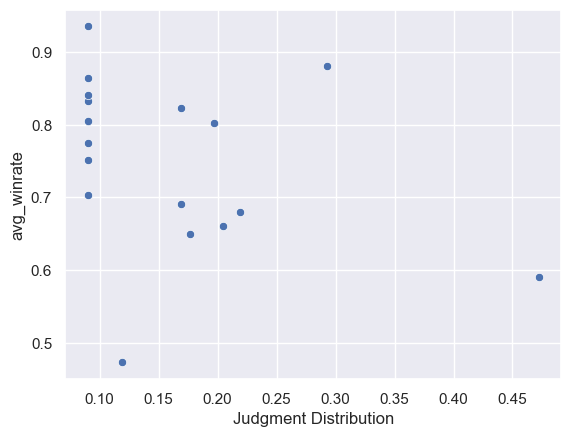

In [120]:
df_viz = pd.DataFrame(data=_dict)
g = sns.scatterplot(data=df_viz, x="Judgment Distribution", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
g

# Visualize based on author attributes
1. by overall F1
2. by minority-class F1

In [163]:
finetune_dir = os.getcwd()+'/outputs/'
model_ckpts = ['distilbert-base-uncased', 'roberta-base', 'deberta-v3-large', 
                'bart-base', 'bart-base_seq2seq', 'flan-t5-base', 'flan-t5-base_seq2seq']
num_folds = 5

In [164]:
def reconstruct_labels_preds(precision, recall, num_support, num_inst, _class):
    if precision == 0:
        _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
        _pred = [1-_class]*num_support + [_class]*(num_inst-num_support)
        return _label, _pred
    tp = round(num_support * recall)
    fn = num_support - tp
    fp = round(tp / precision) - tp
    tn = num_inst - tp - fn - fp
    _label = [_class]*num_support + [1-_class]*(num_inst-num_support)
    _preds = [_class]*tp + [1-_class]*fn + [_class]*fp + [1-_class]*tn
    return _label, _preds

In [165]:
def viz_f1(attribute, attr_dict, mode='overall', group=True, _type='ckpt'):
    _dict = {'author':[], 'fold':[], 'f1':[], f'{attribute}':[], 'ckpt':[]}
    for _filename in os.listdir(finetune_dir):
        if _filename.endswith("results.pkl"):
            _ckpt = _filename.split('_author_')[0]
            with open(f'{finetune_dir}/{_filename}', 'rb') as f:
                _author_results = pickle.load(f)
            for i in range(num_folds):
                for _author in _author_results:
                    _dict['author'].append(_author)
                    _dict['fold'].append(i)
                    _dict['ckpt'].append(_ckpt)
                    _dict[f'{attribute}'].append(attr_dict[_author])
                    if mode == 'overall':
                        _dict['f1'].append(_author_results[_author][i]['macro avg']['f1-score'])
                    elif mode == 'minority':
                        class0sup = _author_results[_author][i]['Not Acceptable']['support']
                        class1sup = _author_results[_author][i]['Acceptable']['support']
                        if class0sup>class1sup:
                            _dict['f1'].append(_author_results[_author][i]['Acceptable']['f1-score'])
                        else:
                            _dict['f1'].append(_author_results[_author][i]['Not Acceptable']['f1-score'])
                    else:
                        raise NotImplementedError
                        
    if group:
        # q = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
        q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        thr = [np.quantile(_dict[f'{attribute}'], _q) for _q in q]
        thr.append(max(_dict[f'{attribute}'])+0.01)
        # print(thr)
        thr_to_type_to_f1 = {str(_thr):{} for _thr in thr}
        for i in range(len(_dict['author'])):
            for _thr in thr:
                if _dict[f'{attribute}'][i] < _thr:
                    if _dict[f'{_type}'][i] not in thr_to_type_to_f1[str(_thr)]:
                        thr_to_type_to_f1[str(_thr)][_dict[f'{_type}'][i]] = []
                    thr_to_type_to_f1[str(_thr)][_dict[f'{_type}'][i]].append(_dict['f1'][i])
                    break
        # print(thr_to_type_to_f1)
        grouped_dict = {'f1':[], 'type':[], f'{attribute}':[]}
        for _thr in thr:
            for _type in thr_to_type_to_f1[str(_thr)]:
                grouped_dict['f1'].append(np.mean(thr_to_type_to_f1[str(_thr)][_type]))
                grouped_dict['type'].append(_type)
                grouped_dict[f'{attribute}'].append(_thr)
        # print(grouped_dict)
        df_viz = pd.DataFrame(data=grouped_dict)
    else:
        df_viz = pd.DataFrame(data=_dict)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", hue='type')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return df_viz
    # sns.catplot(data=df_viz, x=f'{attribute}', y="f1", hue="type", kind="box")
    
    # sns.lineplot(data=df_viz, x=f'{attribute}', y="f1", hue="fold", err_style="bars", errorbar=("se", 2),)
    # sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", )
    # sns.lineplot(data=df_viz, x=f'{attribute}', y="f1", hue="fold",)

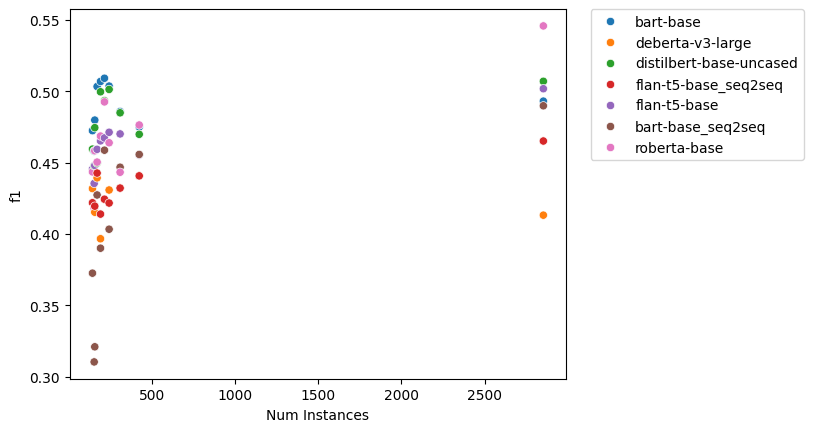

In [16]:
viz_f1('Num Instances', author_to_numInst)

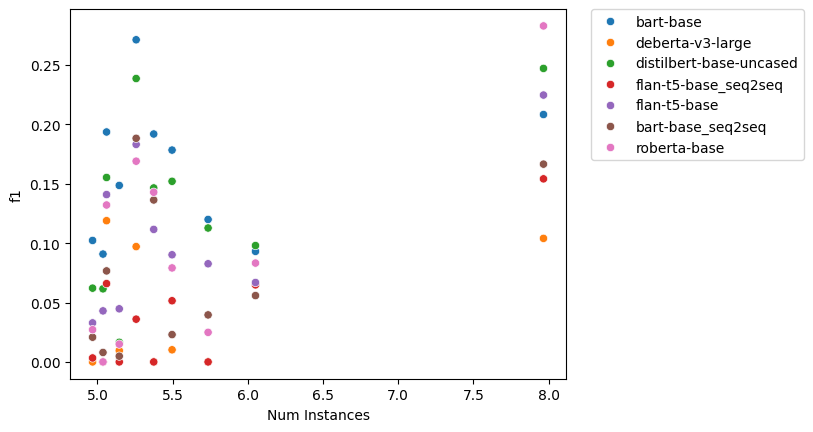

In [26]:
viz_f1('Num Instances', author_to_numInst_log, mode='minority')

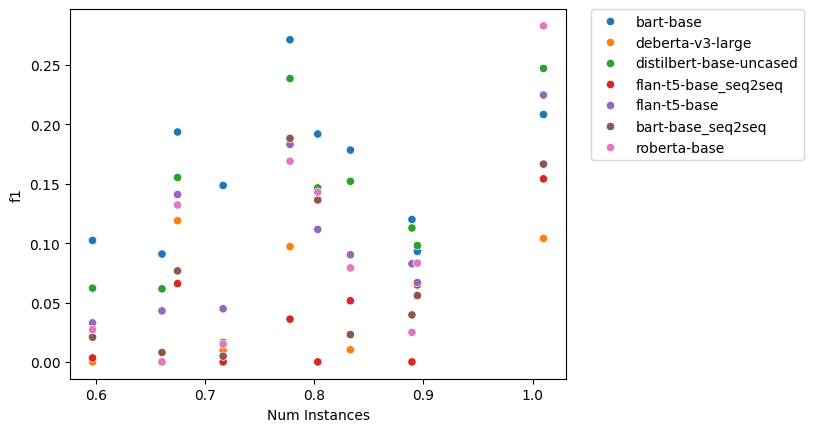

In [28]:
df_viz = viz_f1('Num Instances', author_to_numInst_flat, mode='minority')

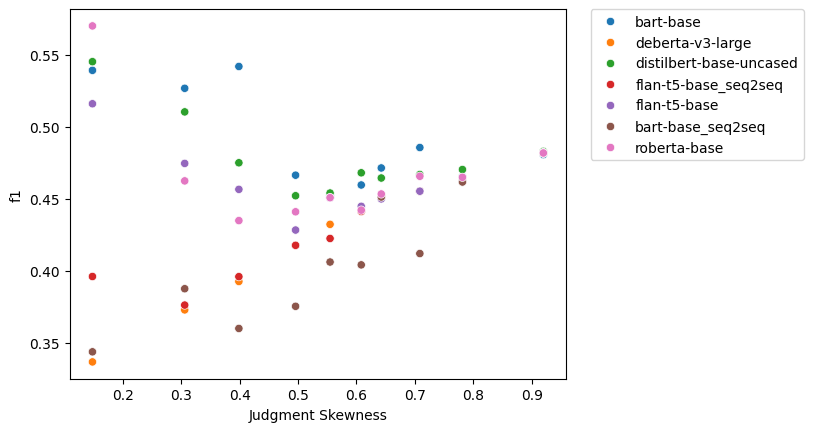

In [30]:
df_viz = viz_f1( 'Judgment Skewness', author_to_judgmentPatterns)

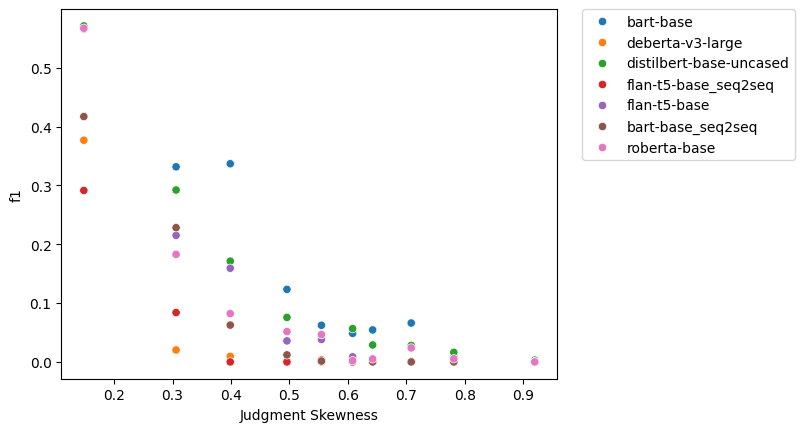

In [31]:
df_viz = viz_f1( 'Judgment Skewness', author_to_judgmentPatterns, mode='minority')

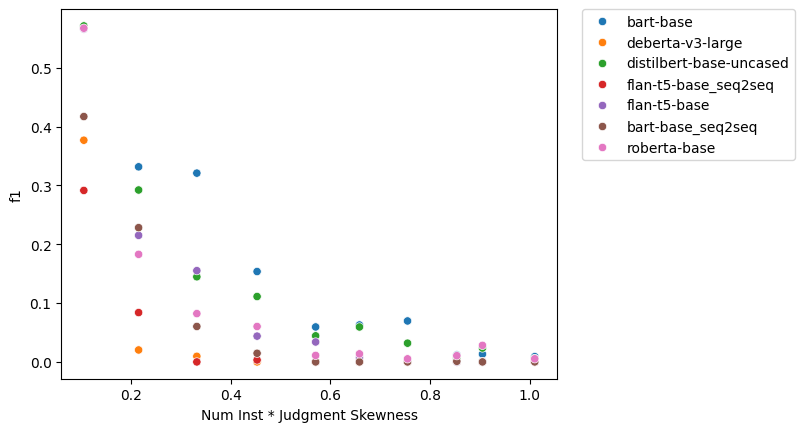

In [57]:
df_viz = viz_f1('Num Inst * Judgment Skewness', author_to_numInst_judgmentPatterns_flat, mode='minority')

# LLMs

In [166]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [167]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue', 'Comm-Value']
inputs =['Comment', 'AbstValue', 'Value', 'Schwartz']
n_trials = 2

In [168]:
def viz_llm_f1(attribute, attr_dict, fix='strategy', strategy='Situation', input='Comment', group=True, pass_list=[], mode='overall'):
    _dict = {'author':[], 'f1':[], f'{attribute}':[], 'type':[]}
    for _filename in os.listdir(output_dir):
        curr_strategy = _filename.split('gpt-4.1_5shots_')[-1].split('withSelftext')[0]
        curr_input = _filename.split('.jsonl')[0].split('withSelftext_')[-1]
        if curr_input in pass_list:
            continue
        target_filepattern = f"_{strategy}withSelftext" if fix == 'strategy' else f"Selftext_{input}.jsonl"
        
        if target_filepattern in _filename:
            control_pattern = curr_input if fix == 'strategy' else curr_strategy
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
                
            author_to_predsANDgolds = {}
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)
                _authors = minidf['custom_id'].apply(lambda x:x.split('-inst_')[0]).tolist()

                for _author, _gold, _pred in zip(_authors, _golds, _preds):
                    if _author not in author_to_predsANDgolds:
                        author_to_predsANDgolds[_author] = {'preds':[], 'golds':[]}
                    author_to_predsANDgolds[_author]['preds'].append(_pred)
                    author_to_predsANDgolds[_author]['golds'].append(_gold)
            
            for _author in author_to_predsANDgolds:
                _dict['author'].append(_author)
                _dict[f'{attribute}'].append(attr_dict[_author])
                _dict['type'].append(control_pattern)
                if mode == 'overall':
                    _dict['f1'].append(f1_score(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], average='macro'))
                elif mode == 'minority':
                    _f1_dict = classification_report(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], target_names=['Not Acceptable','Acceptable'], output_dict=True)
                    class0sup = _f1_dict['Not Acceptable']['support']
                    class1sup = _f1_dict['Acceptable']['support']
                    if class0sup > class1sup:
                        _dict['f1'].append(_f1_dict['Acceptable']['f1-score'])
                    else:
                        _dict['f1'].append(_f1_dict['Not Acceptable']['f1-score'])
                            
    if group:
        # q = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
        q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        thr = [np.quantile(_dict[f'{attribute}'], _q) for _q in q]
        thr.append(max(_dict[f'{attribute}'])+0.01)
        # print(thr)
        thr_to_type_to_f1 = {str(_thr):{} for _thr in thr}
        for i in range(len(_dict['author'])):
            for _thr in thr:
                if _dict[f'{attribute}'][i] < _thr:
                    if _dict['type'][i] not in thr_to_type_to_f1[str(_thr)]:
                        thr_to_type_to_f1[str(_thr)][_dict['type'][i]] = []
                    thr_to_type_to_f1[str(_thr)][_dict['type'][i]].append(_dict['f1'][i])
                    break
        # print(thr_to_type_to_f1)
        grouped_dict = {'f1':[], 'type':[], f'{attribute}':[]}
        for _thr in thr:
            for _type in thr_to_type_to_f1[str(_thr)]:
                grouped_dict['f1'].append(np.mean(thr_to_type_to_f1[str(_thr)][_type]))
                grouped_dict['type'].append(_type)
                grouped_dict[f'{attribute}'].append(_thr)
        # print(grouped_dict)
        df_viz = pd.DataFrame(data=grouped_dict)
    else:
        df_viz = pd.DataFrame(data=_dict)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", hue="type")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return df_viz
    # sns.catplot(data=df_viz, x=f'{attribute}', y="f1", hue="type", kind="box")

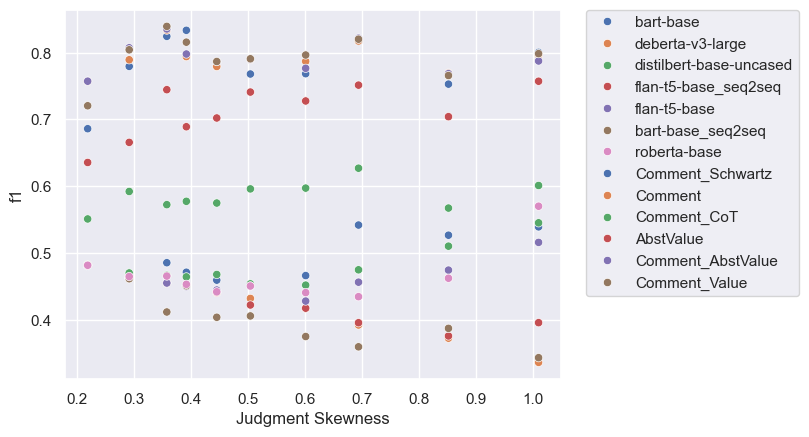

In [192]:
df_viz = viz_f1( 'Judgment Skewness', author_to_judgmentPatterns,)
df_viz_llm = viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns)

In [193]:
df_viz['model_type'] = 'Fine-tuned'
df_viz_llm['model_type'] = 'RAG-based'
df_viz_overall = pd.concat([df_viz, df_viz_llm])

In [194]:
df_viz_overall = df_viz_overall.rename(columns={'type': 'Checkpoint', 'model_type':'Model Type', 'Judgment Skewness':'Distributional Balance of Judgment'})
mapping_dict = {'bart-base':'BART-base', 'roberta-base':'RoBERTa-base'}
df_viz_overall['Checkpoint'] = df_viz_overall['Checkpoint'].apply(lambda x:mapping_dict[x] if x in mapping_dict else x)

<Axes: xlabel='Distributional Balance of Judgment', ylabel='f1'>

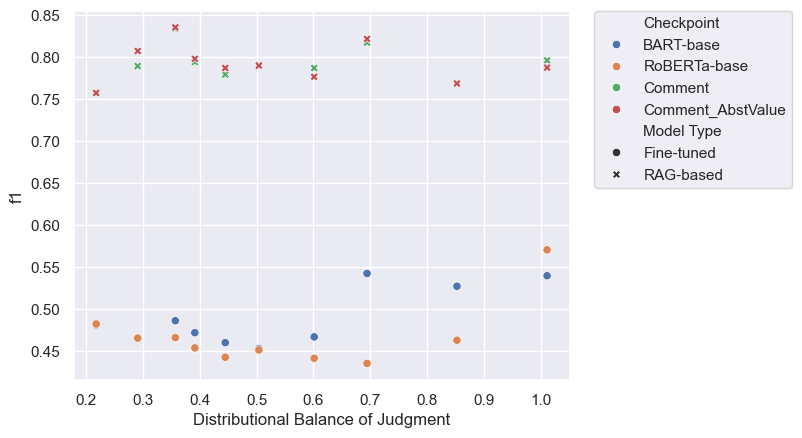

In [196]:
df_viz_overall_focus = df_viz_overall[df_viz_overall['Checkpoint'].isin(['RoBERTa-base', 'BART-base', 'Comment', 'Comment_AbstValue'])]
g = sns.scatterplot(data=df_viz_overall_focus, x="Distributional Balance of Judgment", y="f1", hue="Checkpoint", style="Model Type")

# g = sns.scatterplot(data=df_viz, x="Num Instances (Scaled)", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g

In [197]:
g.figure.savefig(f'{os.getcwd()}/diagram/F1_JudgmentDistribution.png', bbox_inches='tight')

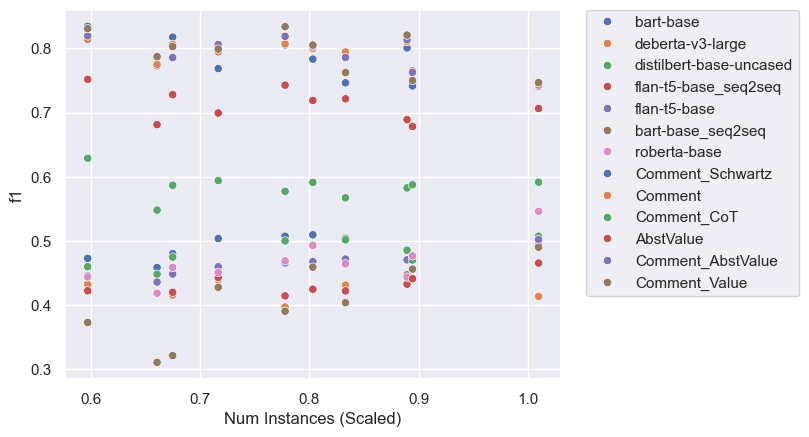

In [200]:
df_viz = viz_f1('Num Instances (Scaled)', author_to_numInst_flat,)
df_viz_llm = viz_llm_f1('Num Instances (Scaled)', author_to_numInst_flat)
df_viz['model_type'] = 'Fine-tuned'
df_viz_llm['model_type'] = 'RAG-based'
df_viz_overall = pd.concat([df_viz, df_viz_llm])
df_viz_overall = df_viz_overall.rename(columns={'type': 'Checkpoint', 'model_type':'Model Type', 'Judgment Skewness':'Distributional Balance of Judgment'})
mapping_dict = {'bart-base':'BART-base', 'roberta-base':'RoBERTa-base'}
df_viz_overall['Checkpoint'] = df_viz_overall['Checkpoint'].apply(lambda x:mapping_dict[x] if x in mapping_dict else x)

<Axes: xlabel='Num Instances (Scaled)', ylabel='f1'>

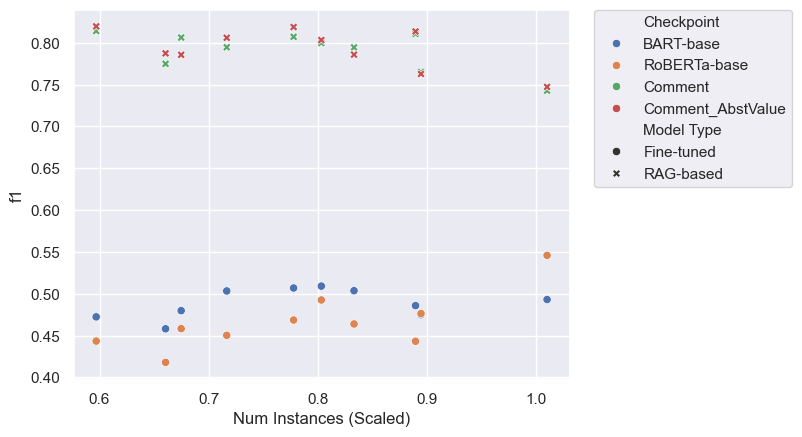

In [201]:
df_viz_overall_focus = df_viz_overall[df_viz_overall['Checkpoint'].isin(['RoBERTa-base', 'BART-base', 'Comment', 'Comment_AbstValue'])]
g = sns.scatterplot(data=df_viz_overall_focus, x="Num Instances (Scaled)", y="f1", hue="Checkpoint", style="Model Type")

# g = sns.scatterplot(data=df_viz, x="Num Instances (Scaled)", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g

In [202]:
g.figure.savefig(f'{os.getcwd()}/diagram/F1_NumInstances.png', bbox_inches='tight')

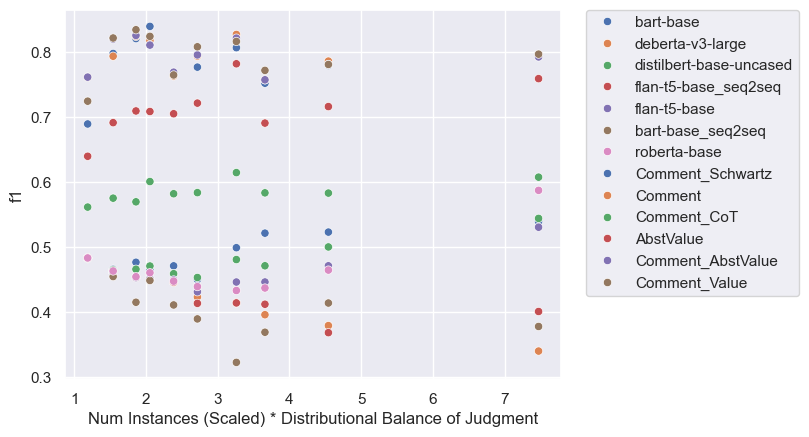

In [203]:
df_viz = viz_f1('Num Instances (Scaled) * Distributional Balance of Judgment', author_to_numInst_judgmentPatterns,)
df_viz_llm = viz_llm_f1('Num Instances (Scaled) * Distributional Balance of Judgment', author_to_numInst_judgmentPatterns)
df_viz['model_type'] = 'Fine-tuned'
df_viz_llm['model_type'] = 'RAG-based'
df_viz_overall = pd.concat([df_viz, df_viz_llm])
df_viz_overall = df_viz_overall.rename(columns={'type': 'Checkpoint', 'model_type':'Model Type'})
mapping_dict = {'bart-base':'BART-base', 'roberta-base':'RoBERTa-base'}
df_viz_overall['Checkpoint'] = df_viz_overall['Checkpoint'].apply(lambda x:mapping_dict[x] if x in mapping_dict else x)

<Axes: xlabel='Num Instances (Scaled) * Distributional Balance of Judgment', ylabel='f1'>

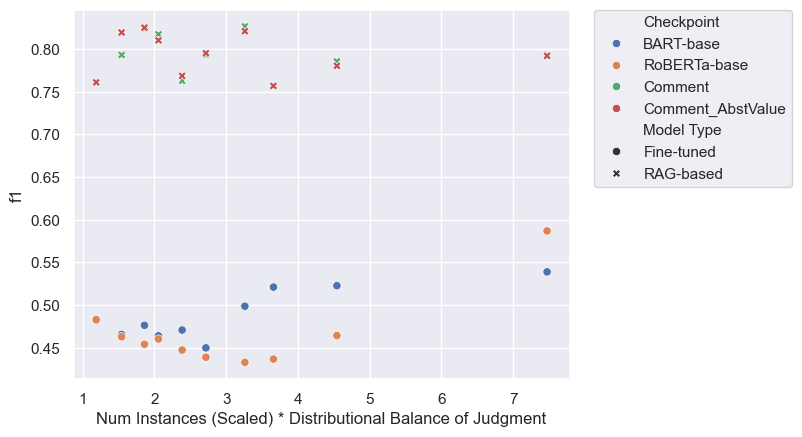

In [204]:
df_viz_overall_focus = df_viz_overall[df_viz_overall['Checkpoint'].isin(['RoBERTa-base', 'BART-base', 'Comment', 'Comment_AbstValue'])]
g = sns.scatterplot(data=df_viz_overall_focus, x="Num Instances (Scaled) * Distributional Balance of Judgment", y="f1", hue="Checkpoint", style="Model Type")

# g = sns.scatterplot(data=df_viz, x="Num Instances (Scaled)", y="avg_winrate",)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# g.set_xticklabels(g.get_xticklabels(),rotation=45,ha='right' , rotation_mode='anchor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g

In [205]:
g.figure.savefig(f'{os.getcwd()}/diagram/F1_NumInstances_JudgmentDistribution.png', bbox_inches='tight')

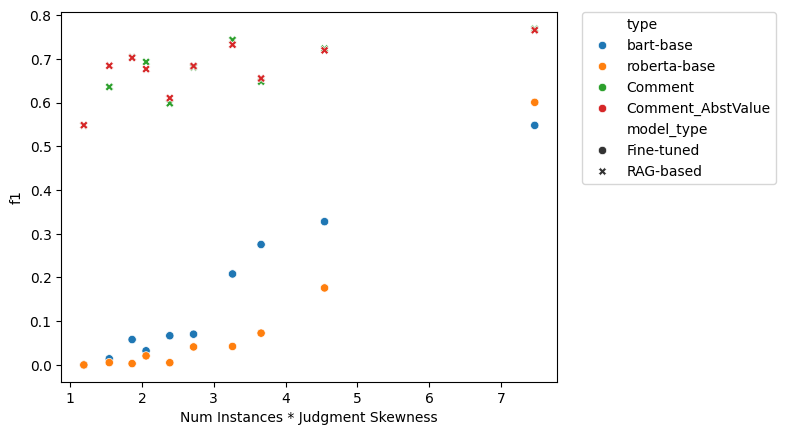

In [68]:
df_viz['model_type'] = 'Fine-tuned'
df_viz_llm['model_type'] = 'RAG-based'
df_viz_overall = pd.concat([df_viz, df_viz_llm])

df_viz_overall_focus = df_viz_overall[df_viz_overall['type'].isin(['roberta-base', 'bart-base', 'Comment', 'Comment_AbstValue'])]
sns.scatterplot(data=df_viz_overall_focus, x="Num Instances * Judgment Skewness", y="f1", hue="type", style="model_type")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

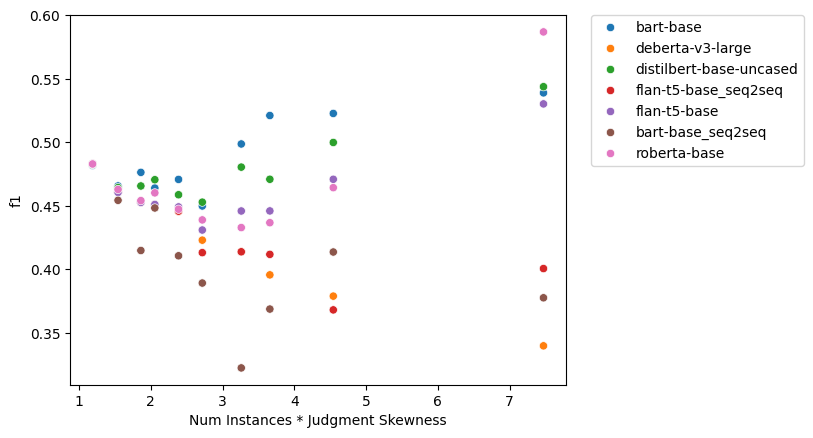

In [69]:
df_viz = viz_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns,)

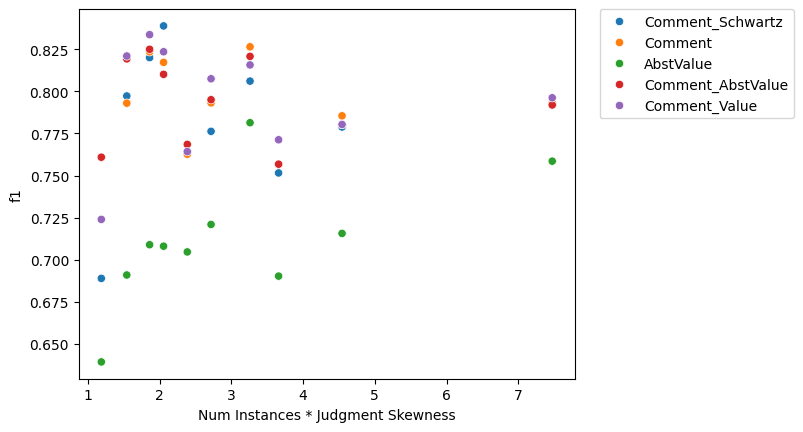

In [70]:
df_viz_llm = viz_llm_f1('Num Instances * Judgment Skewness', author_to_numInst_judgmentPatterns)


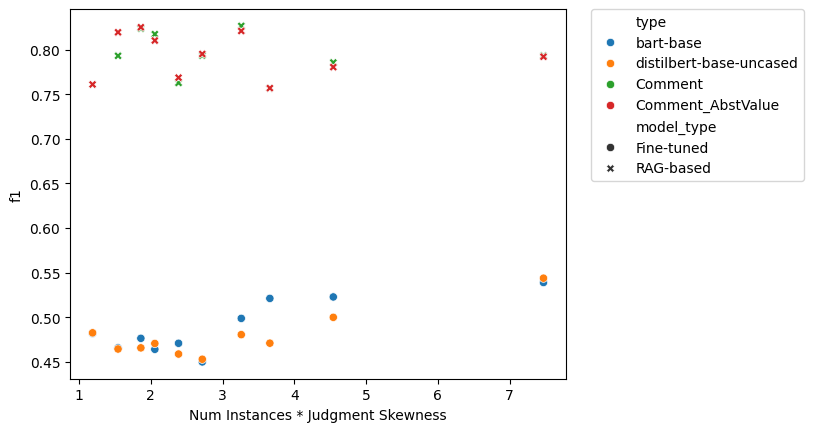

In [74]:
df_viz['model_type'] = 'Fine-tuned'
df_viz_llm['model_type'] = 'RAG-based'
df_viz_overall = pd.concat([df_viz, df_viz_llm])

df_viz_overall_focus = df_viz_overall[df_viz_overall['type'].isin([ 'bart-base', 'distilbert-base-uncased', 'Comment', 'Comment_AbstValue',])]
sns.scatterplot(data=df_viz_overall_focus, x="Num Instances * Judgment Skewness", y="f1", hue="type", style="model_type")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Regression

In [162]:
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

In [164]:
_ckpt = 'roberta-base'
finetune_dir = os.getcwd()+'/outputs/'
with open(f'{finetune_dir}/{_ckpt}_author_results.pkl', 'rb') as f:
    _author_results = pickle.load(f)

In [166]:
for i in range(5):
    X, y = [], []
    for _author in _author_results:
        
        X.append([np.log(author_to_numInst[_author]), author_to_judgmentPatterns[_author], author_to_majorityRatio[_author], author_to_controversialRatio[_author]])
        y.append(_author_results[_author][i]['macro avg']['f1-score'])
    reg = LinearRegression().fit(X, y)
    # reg = linear_model.Lasso().fit(X, y)

    # pr = PolynomialFeatures(degree = 4)
    # X_poly = pr.fit_transform(X)
    # reg2 = LinearRegression().fit(X_poly, y)

    print(f"===[Fold {i}]===")
    print(reg.score(X, y))
    print(reg.coef_)
    print(reg.intercept_)
    # print(reg2.score(X_poly, y))
    # print(reg2.coef_)
    # print(reg2.intercept_)
    
    print()

===[Fold 0]===
0.32085476728972784
[ 0.0472519  -0.07614598 -0.12122737 -0.0794376 ]
0.24964976336209482

===[Fold 1]===
0.22725145164420468
[ 0.04134979 -0.10358181 -0.50361341  0.01819192]
0.31094713716962186

===[Fold 2]===
0.21229652870623583
[ 0.03719109 -0.07660215 -0.60194247  0.19363429]
0.30248299507985554

===[Fold 3]===
0.24691539805363538
[ 0.03940448 -0.10452295 -0.57692984 -0.12391208]
0.32731938076068495

===[Fold 4]===
0.2235736522570897
[ 0.03621385 -0.10697475 -0.51139569  0.08485028]
0.3338952015942574



In [105]:
X, y = [], []
for _author in _author_results:
    X.append([np.log(author_to_numInst[_author]), author_to_judgmentPatterns[_author], author_to_majorityRatio[_author], author_to_HardRatio[_author]])
    y.append(_author_results[_author][0]['macro avg']['f1-score'])

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'lightcoral')
plt.plot(X, lr_2.predict(X_poly), color = 'firebrick')
plt.title('Real data (Polynomial Regression)')
plt.xlabel('Position Level')
plt.ylabel('Salary')
plt.legend(['X/y_pred_poly', 'X/y'], title = 'Salary/Level', loc='best', facecolor='white')
plt.box(False)
plt.show()

np.float64(0.03660951131769479)

In [111]:
X_poly

array([[1.00000000e+00, 7.95612635e+00, 7.72870662e-01, ...,
        2.12721427e-04, 3.70274005e-04, 6.44518237e-04],
       [1.00000000e+00, 7.90544165e+00, 5.29498525e-01, ...,
        9.38318932e-07, 5.31505426e-06, 3.01068228e-05],
       [1.00000000e+00, 7.86441990e+00, 4.74452555e-01, ...,
        3.11897017e-04, 7.43598207e-04, 1.77282328e-03],
       ...,
       [1.00000000e+00, 4.93447393e+00, 7.62589928e-01, ...,
        1.18912223e-05, 3.12776886e-05, 8.22702475e-05],
       [1.00000000e+00, 4.91998093e+00, 6.86131387e-01, ...,
        8.73889134e-06, 1.58271590e-05, 2.86648446e-05],
       [1.00000000e+00, 4.92725369e+00, 7.97101449e-01, ...,
        3.40342168e-05, 8.67621241e-05, 2.21179357e-04]], shape=(100, 70))

# LLM results

In [118]:
output_dir = os.getcwd()+'/gpt_inference/deepseek-chat/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue']

# strategies = [ 'Schwartz',]
n_trials = 2

In [22]:
for _strategy in strategies:
    trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
    for _filename in os.listdir(output_dir):
        if _filename.endswith('.tsv') and f"_{_strategy}withSelftext" in _filename:
            df_ans = pd.read_csv(output_dir+_filename, sep='\t')
            for i in range(n_trials):
                if f"trial{i}" in _filename:
                    # print(_filename)
                    trial_golds[i] += df_ans['gold'].tolist()
                    trial_preds[i] += df_ans['pred'].tolist()
                    # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
    print(f"\n===={_strategy}====")
    all_golds, all_preds = [], []
    for i in range(n_trials):
        print(f"[Trial {i}]")
        print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
        all_golds += trial_golds[i]
        all_preds += trial_preds[i]
    print("[[Overall]]")
    print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))
    
    


====Situation====
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.6127    0.6927    0.6502      3254
    Acceptable     0.8721    0.8271    0.8490      8242

      accuracy                         0.7891     11496
     macro avg     0.7424    0.7599    0.7496     11496
  weighted avg     0.7986    0.7891    0.7927     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.6132    0.6899    0.6493      3254
    Acceptable     0.8712    0.8282    0.8492      8242

      accuracy                         0.7891     11496
     macro avg     0.7422    0.7591    0.7492     11496
  weighted avg     0.7982    0.7891    0.7926     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.6129    0.6913    0.6498      6508
    Acceptable     0.8716    0.8277    0.8491     16484

      accuracy                         0.7891     22992
     macro avg     0.7423    0.7595    0.7494

In [119]:
trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
for _filename in os.listdir(output_dir):
    if _filename.endswith('.tsv') and f"Comment_AbstValue" in _filename:
        df_ans = pd.read_csv(output_dir+_filename, sep='\t')
        for i in range(n_trials):
            if f"trial{i}" in _filename:
                # print(_filename)
                trial_golds[i] += df_ans['gold'].tolist()
                trial_preds[i] += df_ans['pred'].tolist()
                # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
# print(f"\n===={_strategy}====")
all_golds, all_preds = [], []

for i in range(n_trials):
    print(f"[Trial {i}]")
    print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
    all_golds += trial_golds[i]
    all_preds += trial_preds[i]
print("[[Overall]]")
print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))

[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.5884    0.6882    0.6344      4670
    Acceptable     0.8520    0.7885    0.8190     10629

      accuracy                         0.7579     15299
     macro avg     0.7202    0.7384    0.7267     15299
  weighted avg     0.7715    0.7579    0.7627     15299

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.5870    0.6948    0.6364      3254
    Acceptable     0.8701    0.8070    0.8373      8242

      accuracy                         0.7752     11496
     macro avg     0.7285    0.7509    0.7369     11496
  weighted avg     0.7900    0.7752    0.7805     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.5878    0.6909    0.6352      7924
    Acceptable     0.8599    0.7966    0.8270     18871

      accuracy                         0.7653     26795
     macro avg     0.7239    0.7438    0.7311     26795
  weight

In [47]:
# trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
# for _filename in os.listdir(output_dir):
#     if _filename.endswith('.tsv') and f"Comment_AbstValue" in _filename:
df_ans = pd.read_csv(f'{os.getcwd()}/vllm_inference/inferJudgment_5shots_SituationwithSelftext_Comment_trial0.tsv', sep='\t')
#         for i in range(n_trials):
#             if f"trial{i}" in _filename:
#                 # print(_filename)
#                 trial_golds[i] += df_ans['gold'].tolist()
#                 trial_preds[i] += df_ans['pred'].tolist()
#                 # print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))
# # print(f"\n===={_strategy}====")
# all_golds, all_preds = [], []

# for i in range(n_trials):
#     print(f"[Trial {i}]")
#     print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
#     all_golds += trial_golds[i]
#     all_preds += trial_preds[i]
# print("[[Overall]]")
print(classification_report(df_ans['gold'].tolist(), df_ans['pred'].tolist(), target_names=['Not Acceptable','Acceptable'], digits=4))

                precision    recall  f1-score   support

Not Acceptable     0.2309    0.4195    0.2979      3254
    Acceptable     0.6618    0.4484    0.5346      8242

      accuracy                         0.4402     11496
     macro avg     0.4463    0.4340    0.4162     11496
  weighted avg     0.5398    0.4402    0.4676     11496



# Batched LLM Results

In [1]:
import json

In [26]:
output_dir = os.getcwd()+'/gpt_inference/gpt-4.1/'
batchfile_dir = os.getcwd()+'/data/gpt-batchfiles/'
strategies = ['Situation', 'Schwartz', 'Value', 'AbstValue', 'Comm-Value']
inputs =['Comment', 'AbstValue', 'Value', 'Schwartz']
n_trials = 2

In [19]:
def convert_pred_to_digit(labels, preds):
    pred_digits = []
    for _label, _pred in zip(labels, preds):
        if _pred.strip().isdigit():
            pred_digits.append(int(_pred.strip()))
        else:
            if '1' in _pred and '0' not in _pred:
                pred_digits.append(1)
            elif '0' in _pred and '1' not in _pred:
                pred_digits.append(0)
            elif 'acceptable' in _pred.lower() and 'unacceptable' not in _pred.lower():
                pred_digits.append(1)
            elif 'unacceptable' in _pred.lower() and 'Acceptable' not in _pred:
                pred_digits.append(0)
            else:
                pred_digits.append(1-_label)
            
    return pred_digits

In [57]:
def print_overall_results(_strategy, _input):
    trial_golds, trial_preds = {i:[] for i in range(n_trials)}, {i:[] for i in range(n_trials)}
    for _filename in os.listdir(output_dir):
        if f"_{_strategy}withSelftext" in _filename and f"Selftext_{_input}.jsonl" in _filename:
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
            df_list = []
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)

                trial_golds[i] += _golds
                trial_preds[i] += _preds
    print(f"[Strategy] {_strategy}, [Input] {_input}")
    all_golds, all_preds = [], []
    for i in range(n_trials):
        print(f"[Trial {i}]")
        print(classification_report(trial_golds[i], trial_preds[i], target_names=['Not Acceptable','Acceptable'], digits=4))
        all_golds += trial_golds[i]
        all_preds += trial_preds[i]
    print("[[Overall]]")
    print(classification_report(all_golds, all_preds, target_names=['Not Acceptable','Acceptable'], digits=4))

In [59]:
print_overall_results("Situation", 'Comment')

[Strategy] Situation, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8169    0.5867    0.6829      3254
    Acceptable     0.8531    0.9481    0.8981      8242

      accuracy                         0.8458     11496
     macro avg     0.8350    0.7674    0.7905     11496
  weighted avg     0.8429    0.8458    0.8372     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8140    0.5808    0.6779      3254
    Acceptable     0.8513    0.9476    0.8969      8242

      accuracy                         0.8438     11496
     macro avg     0.8326    0.7642    0.7874     11496
  weighted avg     0.8407    0.8438    0.8349     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8154    0.5837    0.6804      6508
    Acceptable     0.8522    0.9478    0.8975     16484

      accuracy                         0.8448     22992
     macro avg     0.8338 

In [62]:
print_overall_results("Situation", 'AbstValue')

[Strategy] Situation, [Input] AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7674    0.5080    0.6113      3254
    Acceptable     0.8286    0.9392    0.8805      8242

      accuracy                         0.8172     11496
     macro avg     0.7980    0.7236    0.7459     11496
  weighted avg     0.8113    0.8172    0.8043     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7670    0.5138    0.6154      3254
    Acceptable     0.8302    0.9384    0.8810      8242

      accuracy                         0.8182     11496
     macro avg     0.7986    0.7261    0.7482     11496
  weighted avg     0.8123    0.8182    0.8058     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7672    0.5109    0.6134      6508
    Acceptable     0.8294    0.9388    0.8807     16484

      accuracy                         0.8177     22992
     macro avg     0.798

In [46]:
print_overall_results("Situation", 'Comment_Value')

11496 11496
[Strategy] Situation, [Input] Comment_Value
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8088    0.5968    0.6868      3254
    Acceptable     0.8557    0.9443    0.8978      8242

      accuracy                         0.8459     11496
     macro avg     0.8323    0.7706    0.7923     11496
  weighted avg     0.8425    0.8459    0.8381     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8083    0.5962    0.6862      3254
    Acceptable     0.8555    0.9442    0.8977      8242

      accuracy                         0.8457     11496
     macro avg     0.8319    0.7702    0.7920     11496
  weighted avg     0.8422    0.8457    0.8378     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8086    0.5965    0.6865      6508
    Acceptable     0.8556    0.9442    0.8978     16484

      accuracy                         0.8458     22992
     mac

In [48]:
print_overall_results("Situation", 'Comment_Schwartz')

11496 11496
[Strategy] Situation, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7990    0.5827    0.6739      3254
    Acceptable     0.8511    0.9421    0.8943      8242

      accuracy                         0.8404     11496
     macro avg     0.8251    0.7624    0.7841     11496
  weighted avg     0.8364    0.8404    0.8319     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7994    0.5817    0.6734      3254
    Acceptable     0.8509    0.9424    0.8943      8242

      accuracy                         0.8403     11496
     macro avg     0.8252    0.7621    0.7839     11496
  weighted avg     0.8363    0.8403    0.8318     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7992    0.5822    0.6737      6508
    Acceptable     0.8510    0.9422    0.8943     16484

      accuracy                         0.8403     22992
     

In [49]:
print_overall_results("Situation", 'Comment_AbstValue')

11496 11496
[Strategy] Situation, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8175    0.5824    0.6802      3254
    Acceptable     0.8519    0.9487    0.8977      8242

      accuracy                         0.8450     11496
     macro avg     0.8347    0.7655    0.7889     11496
  weighted avg     0.8422    0.8450    0.8361     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8183    0.5842    0.6817      3254
    Acceptable     0.8525    0.9488    0.8981      8242

      accuracy                         0.8456     11496
     macro avg     0.8354    0.7665    0.7899     11496
  weighted avg     0.8428    0.8456    0.8368     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8179    0.5833    0.6810      6508
    Acceptable     0.8522    0.9487    0.8979     16484

      accuracy                         0.8453     22992
    

In [33]:
print_overall_results("Value", 'Comment')

[Strategy] Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5814    0.6766      3254
    Acceptable     0.8513    0.9458    0.8960      8242

      accuracy                         0.8426     11496
     macro avg     0.8301    0.7636    0.7863     11496
  weighted avg     0.8393    0.8426    0.8339     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8107    0.5842    0.6790      3254
    Acceptable     0.8521    0.9461    0.8967      8242

      accuracy                         0.8437     11496
     macro avg     0.8314    0.7652    0.7879     11496
  weighted avg     0.8404    0.8437    0.8351     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8098    0.5828    0.6778      6508
    Acceptable     0.8517    0.9459    0.8964     16484

      accuracy                         0.8432     22992
     macro avg     0.8307    0

In [50]:
print_overall_results("Value", 'Comment_Value')

11496 11496
[Strategy] Value, [Input] Comment_Value
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8016    0.5910    0.6803      3254
    Acceptable     0.8537    0.9422    0.8958      8242

      accuracy                         0.8428     11496
     macro avg     0.8276    0.7666    0.7881     11496
  weighted avg     0.8389    0.8428    0.8348     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8004    0.5904    0.6795      3254
    Acceptable     0.8535    0.9419    0.8955      8242

      accuracy                         0.8424     11496
     macro avg     0.8269    0.7661    0.7875     11496
  weighted avg     0.8384    0.8424    0.8344     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8010    0.5907    0.6799      6508
    Acceptable     0.8536    0.9421    0.8956     16484

      accuracy                         0.8426     22992
     macro a

In [29]:
print_overall_results("AbstValue", 'Comment')

[Strategy] AbstValue, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8085    0.5774    0.6737      3254
    Acceptable     0.8501    0.9460    0.8955      8242

      accuracy                         0.8417     11496
     macro avg     0.8293    0.7617    0.7846     11496
  weighted avg     0.8383    0.8417    0.8327     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8089    0.5802    0.6757      3254
    Acceptable     0.8509    0.9459    0.8959      8242

      accuracy                         0.8424     11496
     macro avg     0.8299    0.7630    0.7858     11496
  weighted avg     0.8390    0.8424    0.8336     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8087    0.5788    0.6747      6508
    Acceptable     0.8505    0.9459    0.8957     16484

      accuracy                         0.8420     22992
     macro avg     0.8296 

In [51]:
print_overall_results("AbstValue", 'Comment_AbstValue')

11496 11496
[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
    

In [30]:
print_overall_results("Schwartz", 'Comment')

[Strategy] Schwartz, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8101    0.5808    0.6766      3254
    Acceptable     0.8511    0.9463    0.8962      8242

      accuracy                         0.8428     11496
     macro avg     0.8306    0.7635    0.7864     11496
  weighted avg     0.8395    0.8428    0.8340     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8147    0.5836    0.6800      3254
    Acceptable     0.8522    0.9476    0.8973      8242

      accuracy                         0.8446     11496
     macro avg     0.8334    0.7656    0.7887     11496
  weighted avg     0.8415    0.8446    0.8358     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8124    0.5822    0.6783      6508
    Acceptable     0.8516    0.9469    0.8968     16484

      accuracy                         0.8437     22992
     macro avg     0.8320  

In [34]:
print_overall_results("Schwartz", 'Comment_Schwartz')

[Strategy] Schwartz, [Input] Comment_Schwartz
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7789    0.5685    0.6573      3254
    Acceptable     0.8461    0.9363    0.8889      8242

      accuracy                         0.8322     11496
     macro avg     0.8125    0.7524    0.7731     11496
  weighted avg     0.8271    0.8322    0.8233     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7791    0.5722    0.6598      3254
    Acceptable     0.8471    0.9359    0.8893      8242

      accuracy                         0.8330     11496
     macro avg     0.8131    0.7541    0.7746     11496
  weighted avg     0.8279    0.8330    0.8244     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7790    0.5704    0.6586      6508
    Acceptable     0.8466    0.9361    0.8891     16484

      accuracy                         0.8326     22992
     macro avg    

In [47]:
print_overall_results("Comm-Value", 'Comment')

11496 11496
[Strategy] Comm-Value, [Input] Comment
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8034    0.5713    0.6677      3254
    Acceptable     0.8481    0.9448    0.8938      8242

      accuracy                         0.8391     11496
     macro avg     0.8257    0.7580    0.7808     11496
  weighted avg     0.8354    0.8391    0.8298     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8041    0.5701    0.6671      3254
    Acceptable     0.8478    0.9452    0.8938      8242

      accuracy                         0.8390     11496
     macro avg     0.8259    0.7576    0.7805     11496
  weighted avg     0.8354    0.8390    0.8297     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8037    0.5707    0.6674      6508
    Acceptable     0.8479    0.9450    0.8938     16484

      accuracy                         0.8390     22992
     macro av

In [61]:
print_overall_results("Comm-Value", 'AbstValue')

[Strategy] Comm-Value, [Input] AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.7461    0.4966    0.5963      3254
    Acceptable     0.8244    0.9333    0.8755      8242

      accuracy                         0.8097     11496
     macro avg     0.7853    0.7149    0.7359     11496
  weighted avg     0.8023    0.8097    0.7965     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.7463    0.5000    0.5988      3254
    Acceptable     0.8254    0.9329    0.8758      8242

      accuracy                         0.8104     11496
     macro avg     0.7858    0.7165    0.7373     11496
  weighted avg     0.8030    0.8104    0.7974     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.7462    0.4983    0.5976      6508
    Acceptable     0.8249    0.9331    0.8757     16484

      accuracy                         0.8100     22992
     macro avg     0.78

In [31]:
print_overall_results("Comm-Value", 'Comment_AbstValue')

[Strategy] Comm-Value, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8032    0.5621    0.6614      3254
    Acceptable     0.8454    0.9456    0.8927      8242

      accuracy                         0.8371     11496
     macro avg     0.8243    0.7539    0.7770     11496
  weighted avg     0.8335    0.8371    0.8272     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8019    0.5587    0.6586      3254
    Acceptable     0.8444    0.9455    0.8921      8242

      accuracy                         0.8360     11496
     macro avg     0.8232    0.7521    0.7753     11496
  weighted avg     0.8324    0.8360    0.8260     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8026    0.5604    0.6600      6508
    Acceptable     0.8449    0.9456    0.8924     16484

      accuracy                         0.8366     22992
     macro avg 

In [36]:
print_overall_results("AbstValue", 'Comment_AbstValue')

[Strategy] AbstValue, [Input] Comment_AbstValue
[Trial 0]
                precision    recall  f1-score   support

Not Acceptable     0.8111    0.5661    0.6668      3254
    Acceptable     0.8469    0.9479    0.8946      8242

      accuracy                         0.8399     11496
     macro avg     0.8290    0.7570    0.7807     11496
  weighted avg     0.8368    0.8399    0.8301     11496

[Trial 1]
                precision    recall  f1-score   support

Not Acceptable     0.8127    0.5655    0.6669      3254
    Acceptable     0.8468    0.9486    0.8948      8242

      accuracy                         0.8401     11496
     macro avg     0.8298    0.7570    0.7809     11496
  weighted avg     0.8372    0.8401    0.8303     11496

[[Overall]]
                precision    recall  f1-score   support

Not Acceptable     0.8119    0.5658    0.6668      6508
    Acceptable     0.8469    0.9483    0.8947     16484

      accuracy                         0.8400     22992
     macro avg  

# Visualize based on authors

In [178]:
def viz_llm_f1(attribute, attr_dict, mode='strategy', strategy='Situation', input='Comment', dropout=0.0, group=True, pass_list=[]):
    _dict = {'author':[], 'f1':[], f'{attribute}':[], 'type':[]}
    for _filename in os.listdir(output_dir):
        curr_strategy = _filename.split('gpt-4.1_5shots_')[-1].split('withSelftext')[0]
        curr_input = _filename.split('.jsonl')[0].split('withSelftext_')[-1]
        if curr_input in pass_list:
            continue
        target_filepattern = f"_{strategy}withSelftext" if mode == 'strategy' else f"Selftext_{input}.jsonl"
        
        if target_filepattern in _filename:
            control_pattern = curr_input if mode == 'strategy' else curr_strategy
            df = pd.read_json(output_dir+_filename, lines=True)
            df['trial'] = df['custom_id'].apply(lambda x:int(x.split('_')[-1]))
            with open(batchfile_dir+_filename.replace(".jsonl", "__gold.pkl"), "rb") as f:
                id_to_gold = pickle.load(f)
                
            author_to_predsANDgolds = {}
            for i in range(n_trials):
                minidf = df[df['trial']==i]
                _golds = minidf['custom_id'].apply(lambda x:id_to_gold[x]).tolist()
                _preds = minidf['response'].apply(lambda x:x['body']['choices'][0]['message']['content'])
                _preds = convert_pred_to_digit(_golds, _preds)
                _authors = minidf['custom_id'].apply(lambda x:x.split('-inst_')[0]).tolist()

                for _author, _gold, _pred in zip(_authors, _golds, _preds):
                    if _author not in author_to_predsANDgolds:
                        author_to_predsANDgolds[_author] = {'preds':[], 'golds':[]}
                    author_to_predsANDgolds[_author]['preds'].append(_pred)
                    author_to_predsANDgolds[_author]['golds'].append(_gold)
            
            for _author in author_to_predsANDgolds:
                _indicator = np.random.choice(2, 1, p=[dropout, 1-dropout])[0]
                if _indicator:
                    _dict['author'].append(_author)
                    _dict['f1'].append(f1_score(author_to_predsANDgolds[_author]['golds'], author_to_predsANDgolds[_author]['preds'], average='macro'))
                    _dict[f'{attribute}'].append(attr_dict[_author])
                    _dict['type'].append(control_pattern)

    if group:
        # q = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
        q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        thr = [np.quantile(_dict[f'{attribute}'], _q) for _q in q]
        thr.append(max(_dict[f'{attribute}'])+0.01)
        # print(thr)
        thr_to_type_to_f1 = {str(_thr):{} for _thr in thr}
        for i in range(len(_dict['author'])):
            for _thr in thr:
                if _dict[f'{attribute}'][i] < _thr:
                    if _dict['type'][i] not in thr_to_type_to_f1[str(_thr)]:
                        thr_to_type_to_f1[str(_thr)][_dict['type'][i]] = []
                    thr_to_type_to_f1[str(_thr)][_dict['type'][i]].append(_dict['f1'][i])
                    break
        # print(thr_to_type_to_f1)
        grouped_dict = {'f1':[], 'type':[], f'{attribute}':[]}
        for _thr in thr:
            for _type in thr_to_type_to_f1[str(_thr)]:
                grouped_dict['f1'].append(np.mean(thr_to_type_to_f1[str(_thr)][_type]))
                grouped_dict['type'].append(_type)
                grouped_dict[f'{attribute}'].append(_thr)
        # print(grouped_dict)
        df_viz = pd.DataFrame(data=grouped_dict)
    else:
        df_viz = pd.DataFrame(data=_dict)
    sns.scatterplot(data=df_viz, x=f'{attribute}', y="f1", hue="type")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # sns.catplot(data=df_viz, x=f'{attribute}', y="f1", hue="type", kind="box")

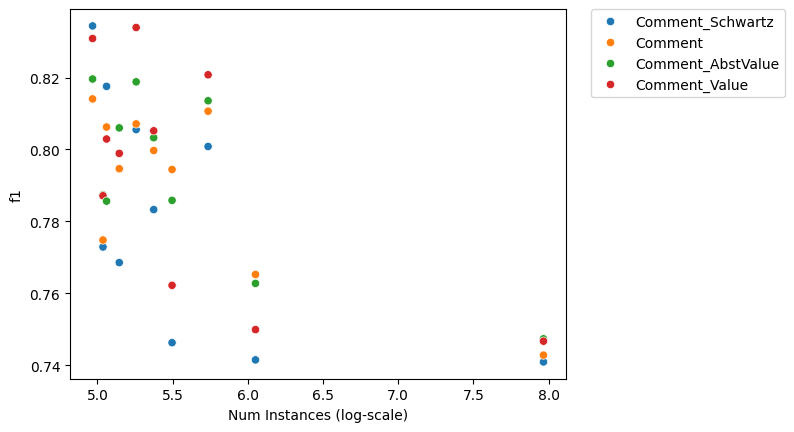

In [133]:
viz_llm_f1('Num Instances (log-scale)', author_to_numInst_log)

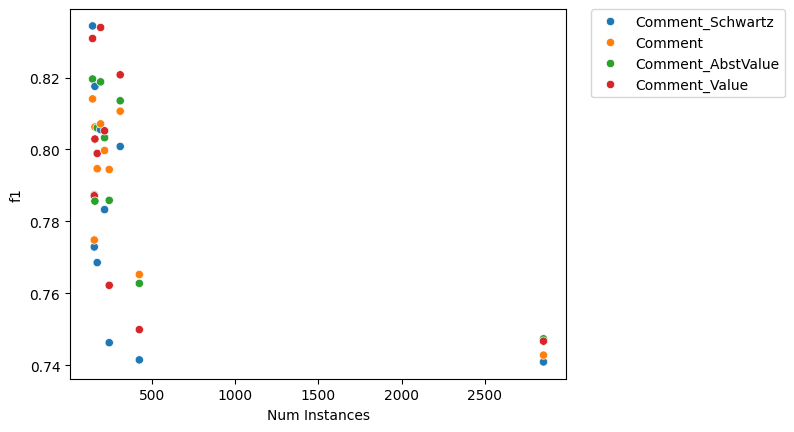

In [134]:
viz_llm_f1('Num Instances', author_to_numInst)

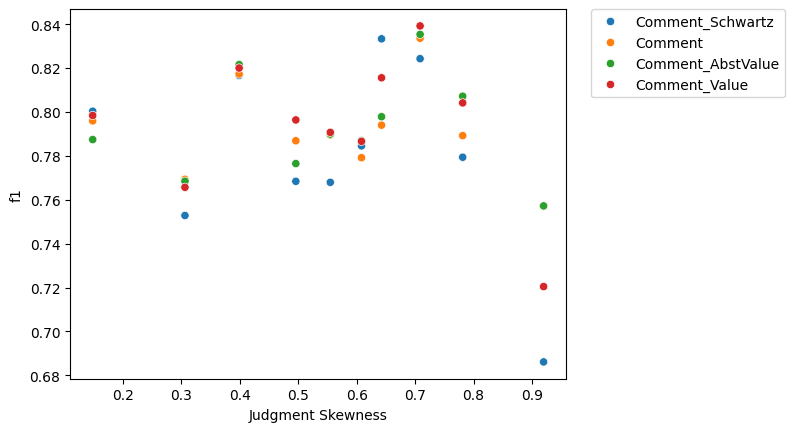

In [135]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns)

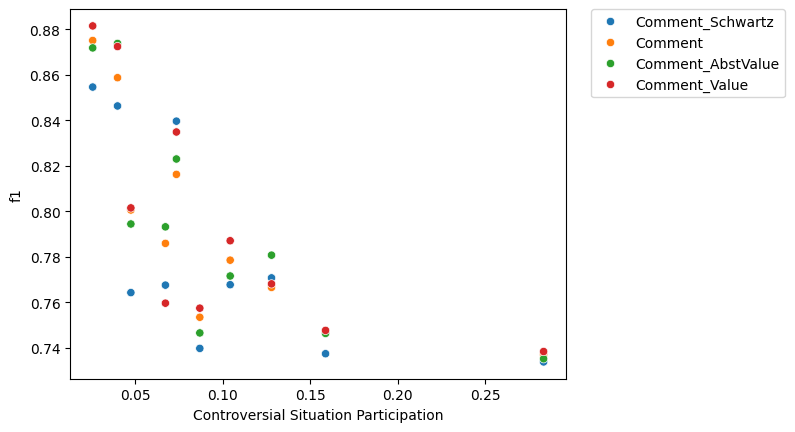

In [136]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio)

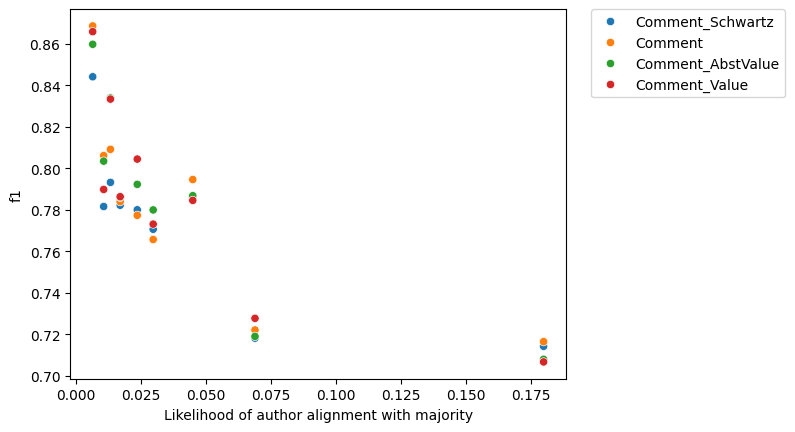

In [137]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio)

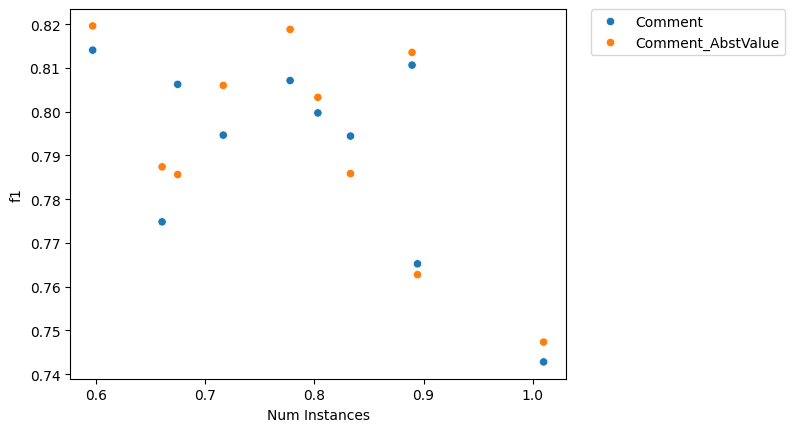

In [179]:
viz_llm_f1('Num Instances', author_to_numInst_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

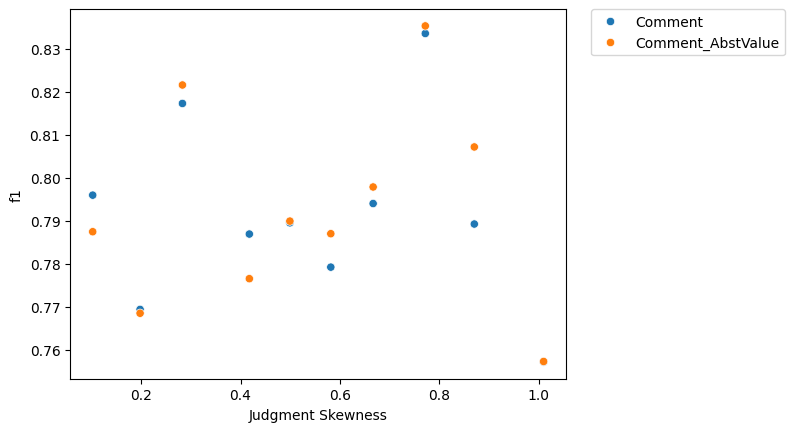

In [180]:
viz_llm_f1('Judgment Skewness', author_to_judgmentPatterns_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

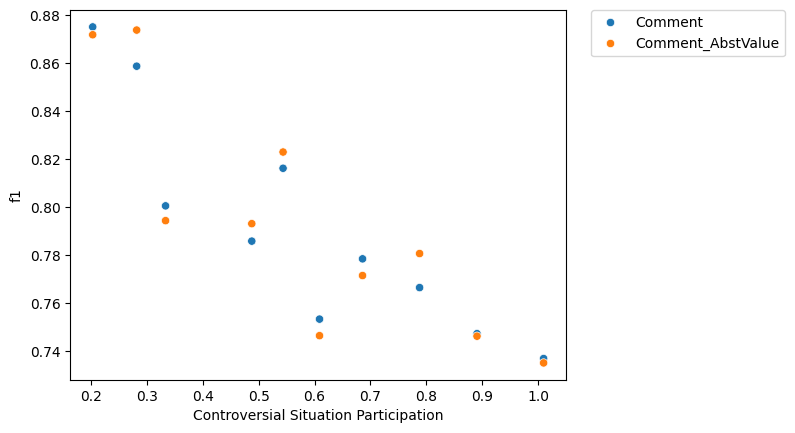

In [181]:
viz_llm_f1('Controversial Situation Participation', author_to_controversialRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])

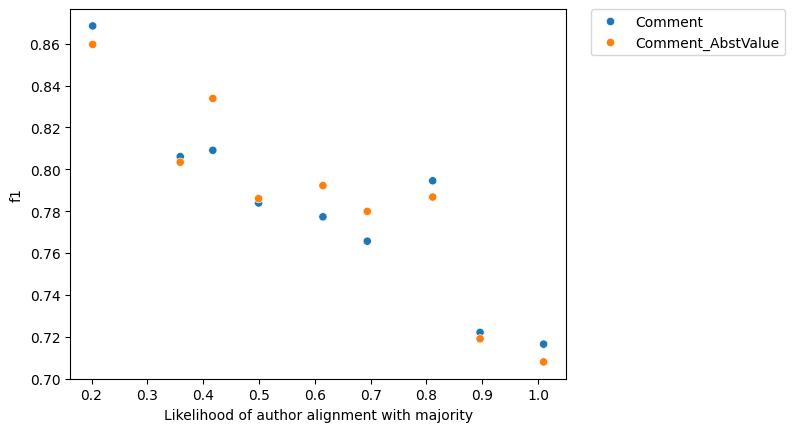

In [182]:
viz_llm_f1('Likelihood of author alignment with majority', author_to_majorityRatio_flat, pass_list=[ "AbstValue", "Comment_Schwartz", "Comment_Value"])